In [3]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal

### Read the root directory of images and extract pixel features and flatten into a 1d vector

In [4]:
dataset_path = 'Lab 2 Data' 
features = []
labels = []

# Loop over each subject folder
for subject_folder in sorted(os.listdir(dataset_path)):
    if subject_folder.startswith('s'):
        subject_number = int(subject_folder[1:])  
        subject_path = os.path.join(dataset_path, subject_folder)

        # Loop over each image in the subject folder
        for image_file in sorted(os.listdir(subject_path)):
            if image_file.endswith('.pgm'):
                image_path = os.path.join(subject_path, image_file)
                
                # Load the image
                img = Image.open(image_path)
                img_array = np.array(img)
                
                # Flatten the image to 1D vector
                flattened_vector = img_array.flatten()

                # Append data and label
                features.append(flattened_vector)
                labels.append(subject_number)

features = np.array(features)
labels = np.array(labels)

print("Features shape:", features.shape)
print("Labels shape:", labels.shape)      

Features shape: (400, 10304)
Labels shape: (400,)


### Sample images for subjects

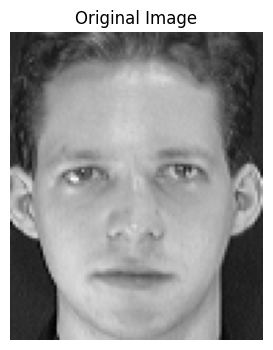

In [5]:
img  = features[0]
original = features[0].reshape(112,92)  # Assuming ORL face dataset shape
plt.figure(figsize=(8, 4))

plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(original, cmap='gray')
plt.axis('off')

plt.show()

### Split Data into Odd indexed rows for training and even indexed for testing

In [6]:
X_train = features[::2]
X_test  = features[1::2] 
y_train = labels[::2]
y_test  = labels[1::2]

### PCA Implementation
Principal Component Analysis (PCA) is a powerful dimensionality reduction technique.
The goal of PCA is:
. To find new axes (called principal components) that capture the most variance in the data.
. Reduce data to fewer dimensions while preserving as much information as possible.
. Remove redundancy (correlated features) by rotating the data into a new orthogonal basis.

#### Approach:
Given a dataset 𝑋 with n samples and d features:

1. Center the Data
Subtract the mean from each feature so that each feature has mean = 0.

2. Compute Covariance Matrix
Calculate how features vary together (covariances).

3. Eigen-Decomposition
Solve for eigenvalues and eigenvectors of the covariance matrix.
Eigenvectors = principal directions (new axes)
Eigenvalues = amount of variance captured by each eigenvector.

4. Sort Eigenvectors
Sort by eigenvalues (highest first).
First eigenvector captures the most variance.
Second eigenvector is orthogonal and captures next most variance, etc.

5. Select Top k Components
Choose the top 𝑘 eigenvectors to preserve a desired amount of variance (e.g., 95%).

6. Project Data
Transform data into the space of top k eigenvectors (lower dimensions).

In [7]:
class PCA:
    def __init__(self, alpha=0.95):
        self.alpha = alpha
        self.cov_matrix = None
        self.eigen_vals = None
        self.eigen_vecs = None
        self.k = None
        self.top_k_vecs = None
        self.mu = None

    def _calculate_covariance(self, X):
        # Compute mean and center data
        self.mu = np.mean(X, axis=0)
        X_centered = X - self.mu
        # Use unbiased estimator: divide by n-1
        cov = (1.0 / (X_centered.shape[0] - 1)) * (X_centered.T @ X_centered)
        return cov

    def fit(self, X):
        # Fit PCA: compute covariance, eigen decomposition, sort, and save
        self.cov_matrix = self._calculate_covariance(X)
        self.eigen_vals, self.eigen_vecs = np.linalg.eigh(self.cov_matrix)

        # Sort eigenvalues and eigenvectors in descending order
        idx = np.argsort(self.eigen_vals)[::-1]
        self.eigen_vals = self.eigen_vals[idx]
        self.eigen_vecs = self.eigen_vecs[:, idx]

        # Save for later use
        np.save(f'eigen_vals_{self.alpha}.npy',self.eigen_vals)
        np.save(f'eigen_vecs_{self.alpha}.npy',self.eigen_vecs)
        np.save(f'means_vector_{self.alpha}.npy',self.mu)
        
        self.set_alpha(self.alpha)

    def load_eigen(self,alpha):
        # Load precomputed eigenvalues, eigenvectors, and mean
        self.eigen_vals = np.load(f'eigen_vals_{alpha}.npy')
        self.eigen_vecs = np.load(f'eigen_vecs_{alpha}.npy')
        self.mu = np.load(f'means_vector_{alpha}.npy')
        self.set_alpha(alpha)

    def set_alpha(self, alpha):
        self.alpha = alpha
        cum_var = np.cumsum(self.eigen_vals)
        total = cum_var[-1]
        ratio = cum_var / total
        self.k = np.searchsorted(ratio, self.alpha, side='right') + 1
        self.k = min(self.k, len(self.eigen_vals))  # Prevent index out of bounds
        self.top_k_vecs = self.eigen_vecs[:, :self.k]


    def transform(self, X):
        if self.mu is None or self.top_k_vecs is None:
            raise ValueError("PCA not fitted. Call .fit() or .load_eigen() first.")
        X_centered = X - self.mu
        return X_centered @ self.top_k_vecs

    def fit_transform(self, X):
        self.fit(X)
        self.set_alpha(self.alpha)
        return self.transform(X)

    def inverse_transform(self, Z):
        self.set_alpha(self.alpha)
        return (Z @ self.top_k_vecs.T) + self.mu


### Try dimensionality reduction on diiferent values of alpha

In [8]:
alphas = [0.8, 0.85, 0.9, 0.95]
X = features 
for alpha in alphas:
    print(f"\n--- PCA with alpha={alpha} ---")
    pca = PCA(alpha=alpha)
    pca.fit(X)


--- PCA with alpha=0.8 ---

--- PCA with alpha=0.85 ---

--- PCA with alpha=0.9 ---

--- PCA with alpha=0.95 ---


Retained dimensions: 44 (out of 10304)


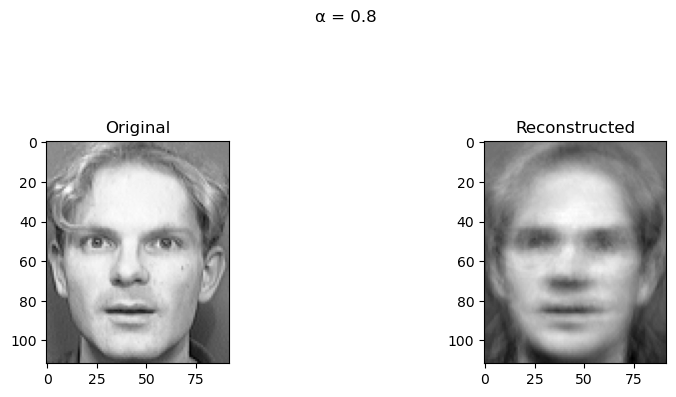

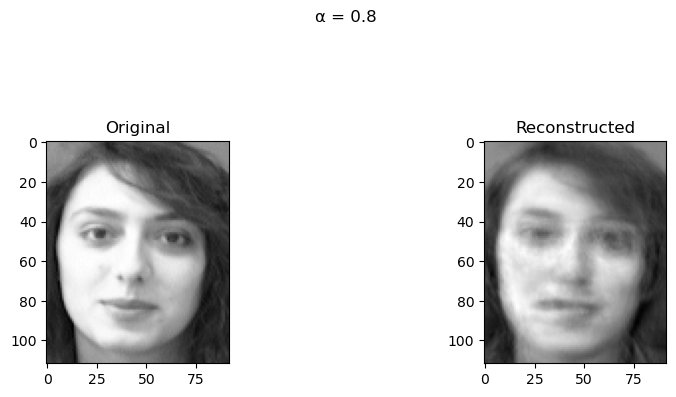

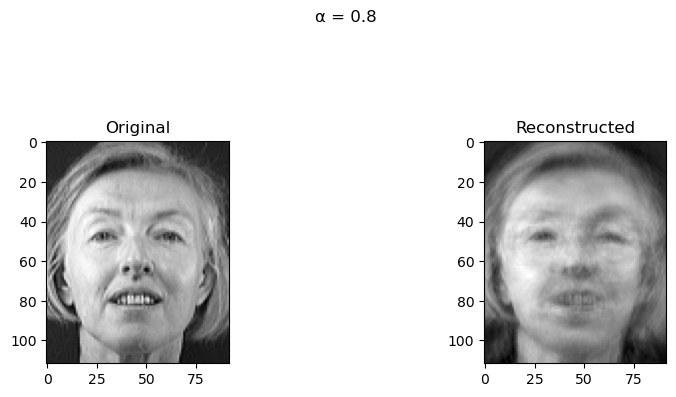

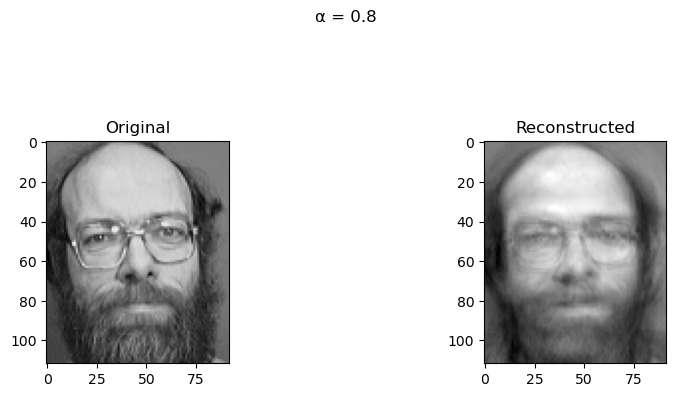

Retained dimensions: 68 (out of 10304)


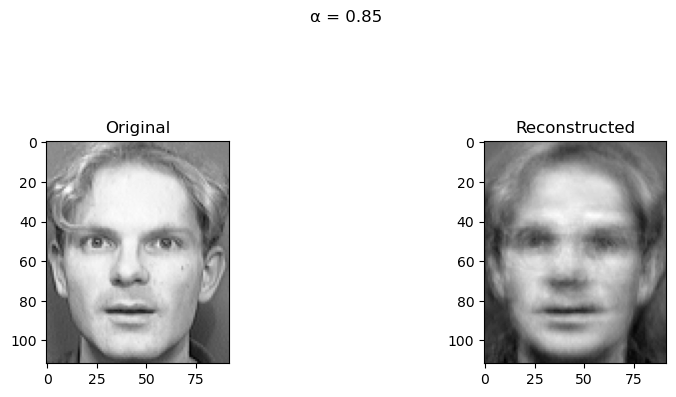

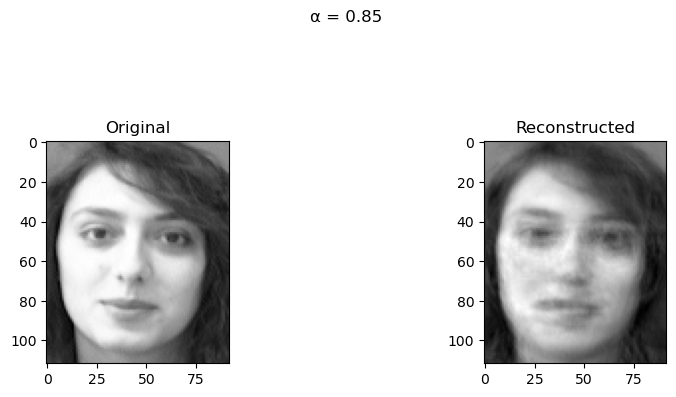

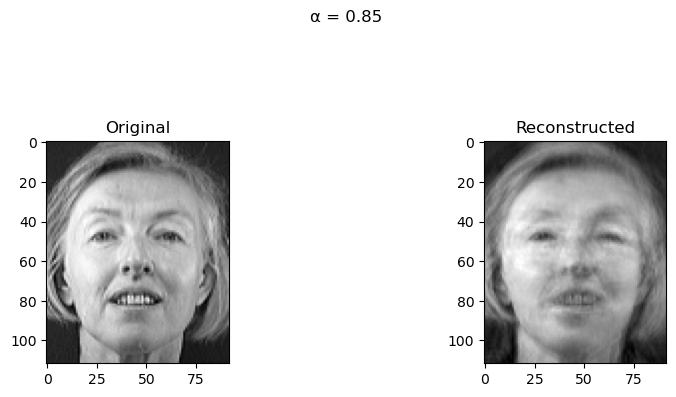

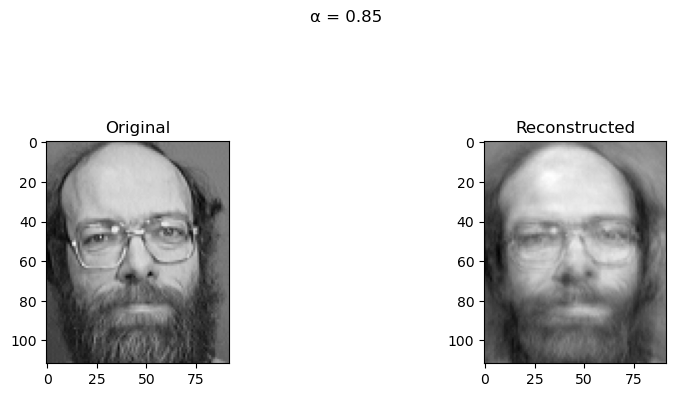

Retained dimensions: 111 (out of 10304)


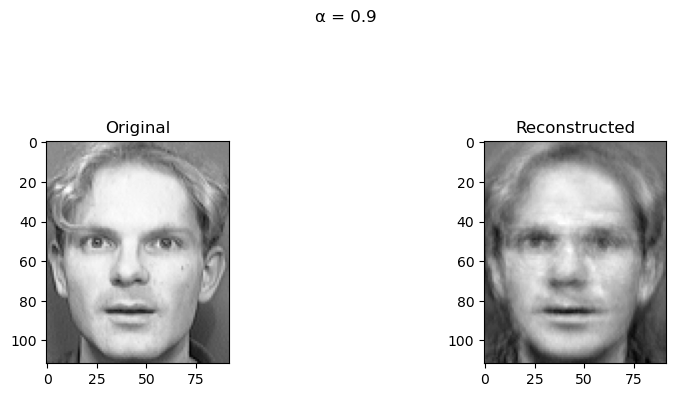

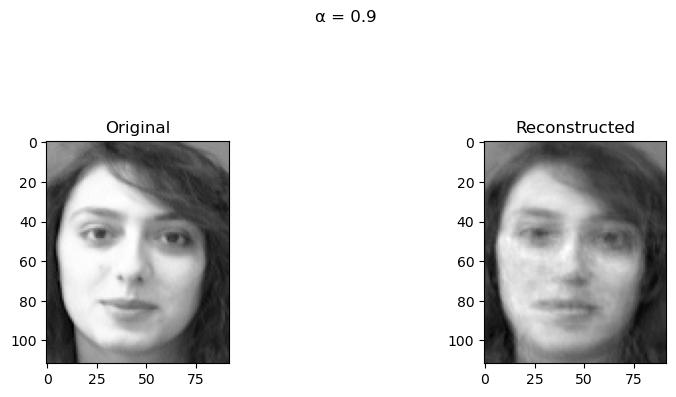

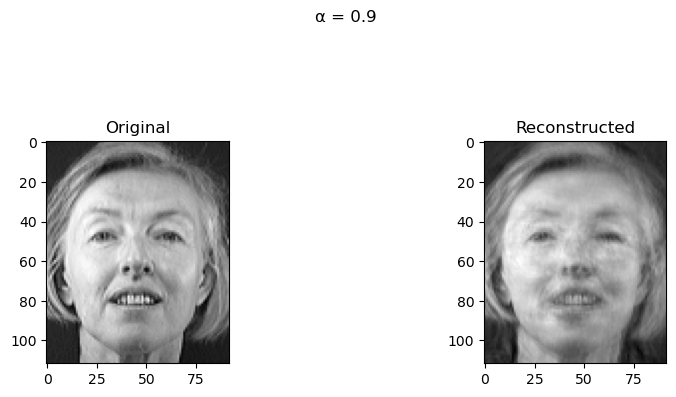

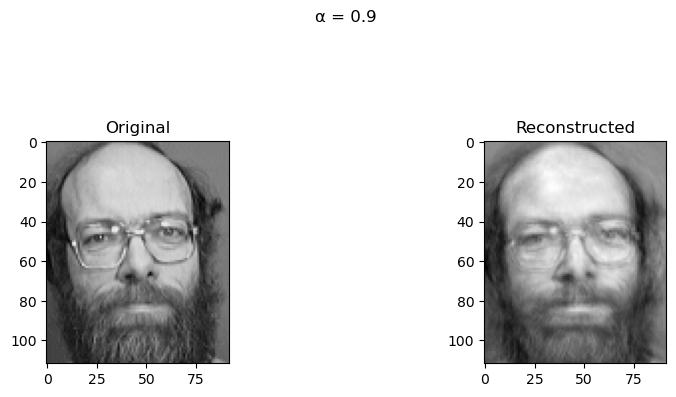

Retained dimensions: 190 (out of 10304)


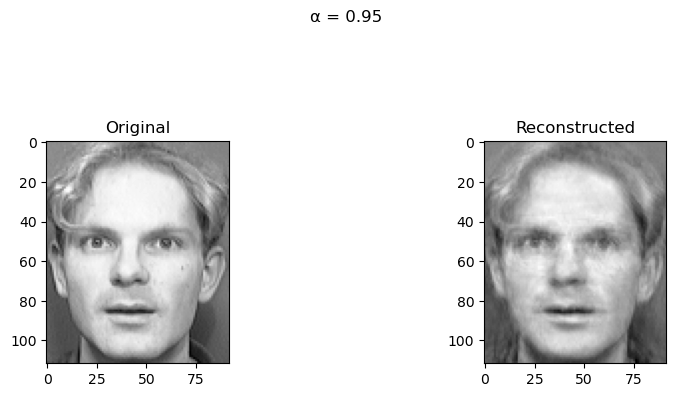

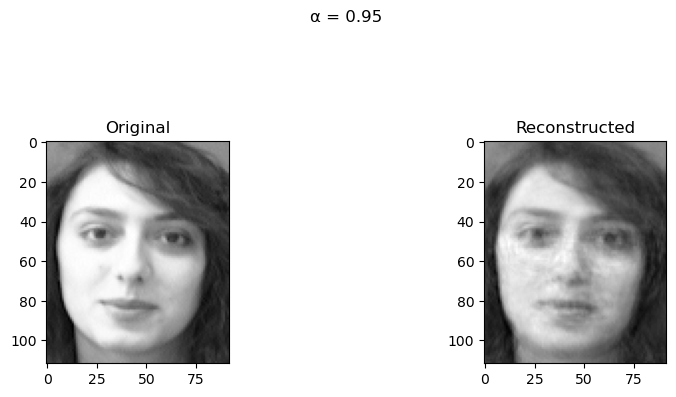

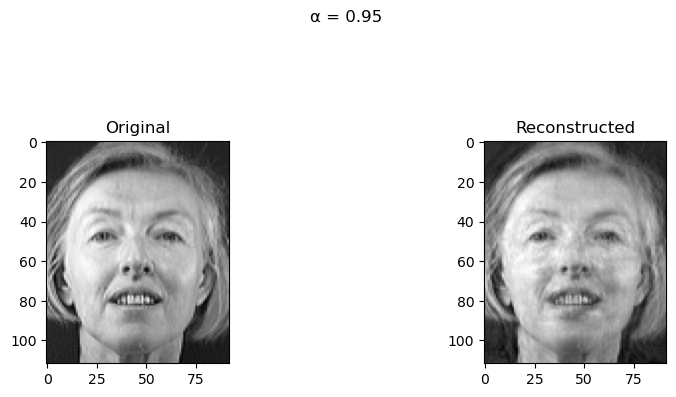

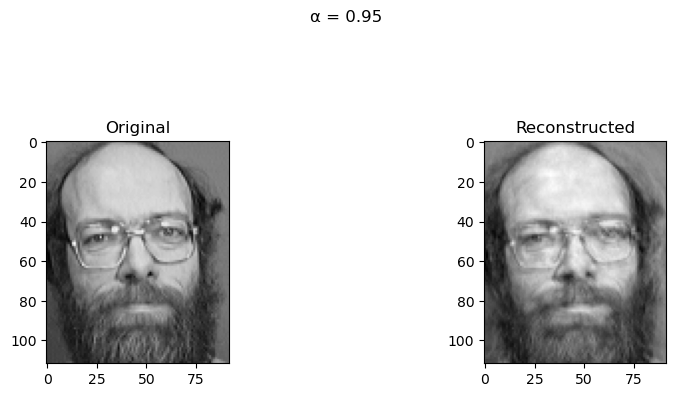

In [ ]:
num_faces = features.shape[0]
random_indices = np.random.choice(num_faces, size=4, replace=False)
random_faces = features[random_indices]


for alpha in alphas:
    pca = PCA(alpha=alpha)
    pca.load_eigen(alpha)
    Z = pca.transform(X)
    # Report dimensionality
    print(f"Retained dimensions: {pca.k} (out of {X.shape[1]})")
    
    # Visualize few transformed vectors
    for i in random_indices:  # visualize 3 random faces
        plt.figure(figsize=(8, 5))
        
        # Original image
        plt.subplot(1, 3, 1)
        plt.imshow(X[i].reshape(112, 92), cmap='gray')  
        plt.title("Original")

        # Reconstructed image
        X_rec = pca.inverse_transform(Z[i])
        plt.subplot(1, 3, 3)
        plt.imshow(X_rec.reshape(112, 92), cmap='gray')
        plt.title("Reconstructed")
        
        plt.suptitle(f"α = {alpha}")
        plt.show()

## Bonus: Design an autoencouder NN

In [24]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import DataLoader, TensorDataset

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [ ]:
class AutoEncoder(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(10304, 5152),
            nn.ReLU(),
            nn.Linear(5152, 2576),
        )
        
        # Decoder 
        self.decoder = nn.Sequential(
            nn.Linear(2576, 5152),
            nn.ReLU(),
            nn.Linear(5152, 10304),
            nn.Sigmoid()        
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [34]:
def train(lr= 0.0005, epochs = 100,features = None):
    features = features.astype(np.float32) 
    features /= 255.0
    
    # Convert features to a Tensor
    features_tensor = torch.from_numpy(features)
    dataset = TensorDataset(features_tensor)

    # Create DataLoader
    dataloader = DataLoader(dataset, batch_size=64, shuffle=True)
    model = AutoEncoder(input_size=10304)  # Make sure to pass input size if needed
    
    Loss = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr)
    
    # Training loop
    for epoch in range(epochs):
        model.train()
        total_loss = 0

        for batch in dataloader:
            inputs = batch[0].to(device)
            
            # Forward pass
            outputs = model(inputs)

            # Compute loss
            loss = Loss(outputs, inputs)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        avg_loss = total_loss / len(dataloader)
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.6f}")

    return model    

In [ ]:
model = train(epochs = 200,features= features)

Epoch [1/50], Loss: 0.041437
Epoch [2/50], Loss: 0.038112
Epoch [3/50], Loss: 0.029571
Epoch [4/50], Loss: 0.025772
Epoch [5/50], Loss: 0.025055
Epoch [6/50], Loss: 0.024829
Epoch [7/50], Loss: 0.025431
Epoch [8/50], Loss: 0.023714
Epoch [9/50], Loss: 0.024535
Epoch [10/50], Loss: 0.024024
Epoch [11/50], Loss: 0.024275
Epoch [12/50], Loss: 0.024461
Epoch [13/50], Loss: 0.024796
Epoch [14/50], Loss: 0.024784
Epoch [15/50], Loss: 0.023693
Epoch [16/50], Loss: 0.024085
Epoch [17/50], Loss: 0.023839
Epoch [18/50], Loss: 0.023049
Epoch [19/50], Loss: 0.022122
Epoch [20/50], Loss: 0.023375
Epoch [21/50], Loss: 0.022618
Epoch [22/50], Loss: 0.023248
Epoch [23/50], Loss: 0.022831
Epoch [24/50], Loss: 0.022802
Epoch [25/50], Loss: 0.022698
Epoch [26/50], Loss: 0.022372
Epoch [27/50], Loss: 0.022693
Epoch [28/50], Loss: 0.022708
Epoch [29/50], Loss: 0.023546
Epoch [30/50], Loss: 0.023021
Epoch [31/50], Loss: 0.022482
Epoch [32/50], Loss: 0.022877
Epoch [33/50], Loss: 0.022387
Epoch [34/50], Loss

In [28]:
# store pickle file
import pickle
with open('autoencoder_model.pkl', 'wb') as f:
    pickle.dump(model, f)

### Use autoencoder to reduce dimensionality of the dataset

In [17]:
def autoencoder_reduce(model, X):
    model.eval()
    X_tensor = torch.from_numpy(X)
    with torch.no_grad():
        encoded_representations = model.encoder(X_tensor)  
    return encoded_representations

### Reconstruct Images using autoencoder network

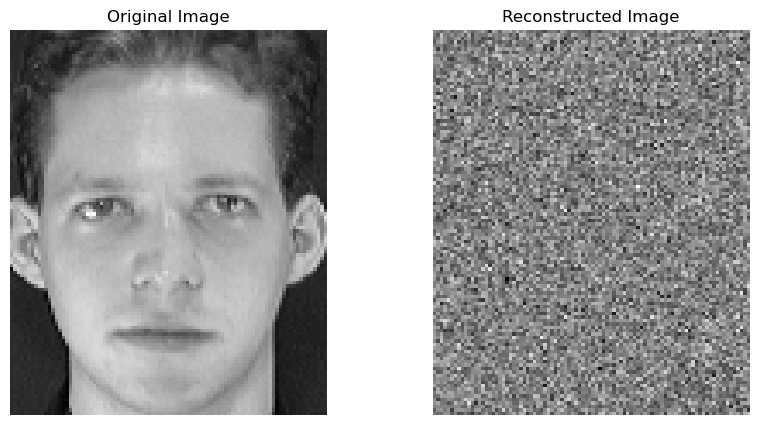

In [ ]:

model = AutoEncoder(input_size=10304).to(device)

sample_idx = 0
sample_image = features[sample_idx]  # shape (10304,)
sample_image_tensor = torch.from_numpy(sample_image).float().to(device)

model.eval()
with torch.no_grad():
    input_tensor = sample_image_tensor.unsqueeze(0)  
    
    reconstructed_tensor = model(input_tensor)  
    
    reconstructed_image = reconstructed_tensor.squeeze(0).cpu().numpy()

original_image = sample_image.reshape(112, 92)
reconstructed_image = reconstructed_image.reshape(112, 92)

plt.figure(figsize=(10,5))

plt.subplot(1, 2, 1)
plt.title('Original Image')
plt.imshow(original_image, cmap='gray')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title('Reconstructed Image')
plt.imshow(reconstructed_image, cmap='gray')
plt.axis('off')

plt.show()

In [1]:
""" 
For implementation of GMM :
1. initialize the parameters of the algorithm
2. Do expectation step: calculating liklihood of each data point to each of the k - clusters and calculating reposibility vetor of each point
3. Do maximization step in which we recompute mean, weights and the Covariance
4. repeat 4, 5 until convergence within toleranece



Algorithm parameter:
self.k --> the number of clusters(gaussians in mixture)
self.pi --> weights of each gaussian(mixing coeffients)=== prio proability of each gaussian
self.means --> contains means vectors of k clusters: each mean vec has dimension (d same as data)
self.covariances --> covariance matrcies of each gaussian each dxd


Methods in class:
_e_step(X):
            1. Calculates Gaussian Likelihood of oint with k clusters
            2. Sets rk as self.weight[k] * likelihood 
            3. scale by sum of the responsibility of a give point
_M_step(X):
            1. Recompute mean as dot product of X and its responsibility and divide byb sumof cluster responsibility
            2. Recompute Covariance according to rule of covariance

_fit(X):
        1. Call _e_step()
        2. Call _M_Step()
"""

' \nFor implementation of GMM :\n1. initialize the parameters of the algorithm\n2. Do expectation step: calculating liklihood of each data point to each of the k - clusters and calculating reposibility vetor of each point\n3. Do maximization step in which we recompute mean, weights and the Covariance\n4. repeat 4, 5 until convergence within toleranece\n\n\n\nAlgorithm parameter:\nself.k --> the number of clusters(gaussians in mixture)\nself.pi --> weights of each gaussian(mixing coeffients)=== prio proability of each gaussian\nself.means --> contains means vectors of k clusters: each mean vec has dimension (d same as data)\nself.covariances --> covariance matrcies of each gaussian each dxd\n\n\nMethods in class:\n_e_step(X):\n            1. Calculates Gaussian Likelihood of oint with k clusters\n            2. Sets rk as self.weight[k] * likelihood \n            3. scale by sum of the responsibility of a give point\n_M_step(X):\n            1. Recompute mean as dot product of X and its

In [28]:
print(Z)

[[ 1429.86234363  1193.58697313 -2013.4661952  ...    -4.9446789
   -105.52757595   -82.46844534]
 [ 2963.04592996  1162.0483341    146.90398565 ...   -95.66533482
    -18.64531324   -91.5803923 ]
 [ 3152.29950972  1467.20016435  -417.78973193 ...   -92.33497522
    -80.55097579   -34.22119357]
 ...
 [ -958.13202037  1223.43385881   349.9111249  ...   -53.71844504
     70.81520085   -19.43775976]
 [-1001.8326715   1109.3318066    679.12012836 ...  -182.27916443
    148.04596955   170.21352454]
 [ -884.83951376  1582.04813205   575.95258289 ...    10.98094237
    174.19746881  -174.80966181]]


In [8]:
class GMM:
    def __init__(self, K, max_iter=500, tol=1e-10):
        self.K = K
        self.max_iter = max_iter
        self.tol = tol
        self.pi = np.ones(self.K) / self.K
        self.responsibilities = None
        self.means = None
        self.covariances = None

    def _e_step(self, X):
        n_samples, _ = X.shape
        log_resp = np.zeros((n_samples, self.K))

        for i in range(self.K):
            try:
                mvn = multivariate_normal(mean=self.means[i], cov=self.covariances[i], allow_singular=True)
                log_resp[:, i] = np.log(np.clip(self.pi[i], 1e-10, 1.0)) + mvn.logpdf(X)
            except:
                log_resp[:, i] = -1e10  # fallback in case of numerical issues

        # Log-sum-exp trick
        max_log = np.max(log_resp, axis=1, keepdims=True)
        log_sum = max_log + np.log(np.sum(np.exp(log_resp - max_log), axis=1, keepdims=True))
        self.responsibilities = np.exp(log_resp - log_sum)

    def _m_step(self, X):
        n_samples, n_features = X.shape
        sigma_R = np.sum(self.responsibilities, axis=0)
        sigma_R[sigma_R == 0] = 1e-6  # prevent divide by zero

        self.means = (self.responsibilities.T @ X) / sigma_R[:, np.newaxis]

        self.covariances = np.zeros((self.K, n_features, n_features))
        for i in range(self.K):
            diff = X - self.means[i]
            weighted_diff = diff.T * self.responsibilities[:, i]
            cov = weighted_diff @ diff / sigma_R[i]
            self.covariances[i] = cov + np.eye(n_features) * 1e-3  # Regularize to ensure PSD

        self.pi = sigma_R / n_samples

    def _compute_log_likelihood(self, X):
        n_samples = X.shape[0]
        log_prob = np.zeros((n_samples, self.K))

        for i in range(self.K):
            try:
                mvn = multivariate_normal(mean=self.means[i], cov=self.covariances[i], allow_singular=True)
                log_prob[:, i] = np.log(np.clip(self.pi[i], 1e-10, 1.0)) + mvn.logpdf(X)
            except:
                log_prob[:, i] = -1e10

        max_log = np.max(log_prob, axis=1, keepdims=True)
        log_sum = max_log + np.log(np.sum(np.exp(log_prob - max_log), axis=1, keepdims=True))
        return np.sum(log_sum)

    def fit(self, X):
        n_samples, n_features = X.shape
        rng = np.random.default_rng()
        self.means = X[rng.choice(n_samples, self.K, replace=False)]
        self.covariances = np.array([
            np.cov(X.T) + np.eye(n_features) * 1e-3 for _ in range(self.K)
        ])
        self.pi = np.ones(self.K) / self.K
        prev_log_likelihood = -np.inf

        for iteration in range(self.max_iter):
            self._e_step(X)
            self._m_step(X)
            current_log_likelihood = self._compute_log_likelihood(X)

            print(f"Iter {iteration + 1}, log-likelihood: {current_log_likelihood:.6f}")

            if np.abs(current_log_likelihood - prev_log_likelihood) < self.tol:
                print(f"Converged at iteration {iteration + 1}")
                break

            prev_log_likelihood = current_log_likelihood

    def predict(self, X):
        self._e_step(X)
        return np.argmax(self.responsibilities, axis=1)

In [15]:
Z = PCA().fit_transform(X_train)
print(Z.shape)

(200, 115)


In [30]:
GMM_model = GMM(K=40)
GMM_model.fit(Z)

Iter 0, log-likelihood: -52804.590885
Iter 1, log-likelihood: 16711.933093
Iter 2, log-likelihood: 17305.556238
Iter 3, log-likelihood: 17297.631846
Iter 4, log-likelihood: 17297.631846
Converged at iteration 4


In [31]:
predictions = GMM_model.predict(Z)
print(predictions)

[24 19 32  9 24 19  6 19  6  6 19 27 19 23  9 36  9 30 36 19 15 15 19 33
 36 19 23 10  9 36 34  0 30 34  9  8 19  9  8  9  2 36  9  4  9 11 11 11
  7  2 36 19  1  9  1 13 27 27  9 11  8 23 39 39 17 19 27  9 11  8  9  8
 18  7 27 10 27 10 10 27 25 32 25 32 32 27  2 38 38 38 23 37  8 23 19 19
  5  9 10 32 23 19 19 23 30  8  8  8  8 12 27  9 14 36  9  9  9  9  9  9
 31  8 21 31 31 19 16 19  9  9  9 19 19 26 10 22 34 30 22 22  8 27 27 35
 35 19 32 10 36  9  6 32  9  9 23  9 28 19 10 28 30 30 25  9 30 19 20 20
  3 36 27 19 19 19 29 19 27 19 19 27 29 36 36 36 29  9 30 19  8 27  0  0
 10  0  9 38 19  8 10  9]


In [9]:
def assign_cluster_labels(cluster_assignments, true_labels):
    """
    Assigns labels to clusters based on majority voting from true labels.
    
    Args:
        cluster_assignments: Array of cluster indices for each sample
        true_labels: Array of true labels for each sample
        
    Returns:
        cluster_to_label: Dictionary mapping from cluster indices to assigned labels
        final_predictions: Array of predicted labels for each sample
    """
    unique_clusters = np.unique(cluster_assignments)
    cluster_to_label = {}
    
    # For each cluster, find the majority true label
    for cluster in unique_clusters:
        # Find all samples in this cluster
        cluster_samples = (cluster_assignments == cluster)
        
        # Get their true labels
        cluster_true_labels = true_labels[cluster_samples]
        
        # Find the most common label
        unique_labels, counts = np.unique(cluster_true_labels, return_counts=True)
        majority_label = unique_labels[np.argmax(counts)]
        cluster_to_label[cluster] = majority_label
        
        # Print cluster statistics
        print(f"Cluster {cluster}: assigned label {majority_label}, contains {len(cluster_true_labels)} samples")
        print(f"  Label distribution: {dict(zip(unique_labels, counts))}")
    
    # Map each sample's cluster to the assigned label
    final_predictions = np.array([cluster_to_label[cluster] for cluster in cluster_assignments])
    
    return cluster_to_label, final_predictions


# Use the function on your data
# Get cluster assignments from GMM predictions
y_pred_clusters = predictions  # This is what you already have

# Assign labels to clusters by majority voting
cluster_to_label, y_pred_labels = assign_cluster_labels(y_pred_clusters, y_train)

# Calculate accuracy of the labeled predictions 
accuracy = np.mean(y_pred_labels == y_train)
print(f"\nAccuracy after cluster labeling: {accuracy * 100:.2f}%")

# Visualize confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_train, y_pred_labels)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

NameError: name 'predictions' is not defined

In [10]:
def gmm_accuracy(gmm_model, X, true_labels, verbose=False):
    """
    Calculate accuracy of GMM clustering after mapping clusters to classes.
    
    Args:
        gmm_model: Trained GMM model
        X: Input features
        true_labels: Ground truth labels
        verbose: Whether to print cluster statistics
        
    Returns:
        tuple: (accuracy, predicted_labels, cluster_to_label_mapping)
    """
    # Get cluster assignments
    cluster_assignments = gmm_model.predict(X)
    
    # Find unique clusters
    unique_clusters = np.unique(cluster_assignments)
    cluster_to_label = {}
    
    # For each cluster, find the majority true label
    for cluster in unique_clusters:
        # Find all samples in this cluster
        cluster_samples = (cluster_assignments == cluster)
        
        # Get their true labels
        cluster_true_labels = true_labels[cluster_samples]
        
        # Find the most common label
        unique_labels, counts = np.unique(cluster_true_labels, return_counts=True)
        majority_label = unique_labels[np.argmax(counts)]
        cluster_to_label[cluster] = majority_label
        
        # Print cluster statistics if verbose
        if verbose:
            print(f"Cluster {cluster}: assigned label {majority_label}, contains {len(cluster_true_labels)} samples")
            print(f"  Label distribution: {dict(zip(unique_labels, counts))}")
    
    # Map each sample's cluster to the assigned label
    predicted_labels = np.array([cluster_to_label[cluster] for cluster in cluster_assignments])
    
    # Calculate accuracy
    accuracy = np.mean(predicted_labels == true_labels)
    
    return accuracy, predicted_labels, cluster_to_label



--- Testing Alpha=0.8, K=20 ---
Iter 1, log-likelihood: -40126.847568
Iter 2, log-likelihood: -14547.482670
Iter 3, log-likelihood: -11796.405561
Iter 4, log-likelihood: -11796.405561
Converged at iteration 4
Alpha: 0.8, K: 20, Train Accuracy: 37.50%
Alpha: 0.8, K: 20, Test Accuracy: 4.50%


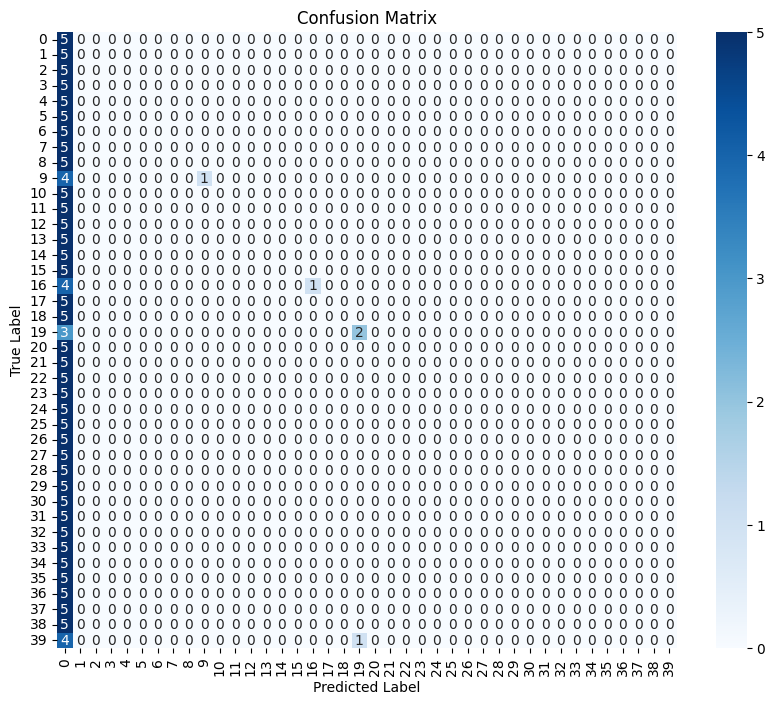


--- Testing Alpha=0.8, K=40 ---
Iter 1, log-likelihood: -30071.829952
Iter 2, log-likelihood: 3344.298847
Iter 3, log-likelihood: 4182.155618
Iter 4, log-likelihood: 4262.238568
Iter 5, log-likelihood: 4262.238568
Converged at iteration 5
Alpha: 0.8, K: 40, Train Accuracy: 60.50%
Alpha: 0.8, K: 40, Test Accuracy: 24.00%


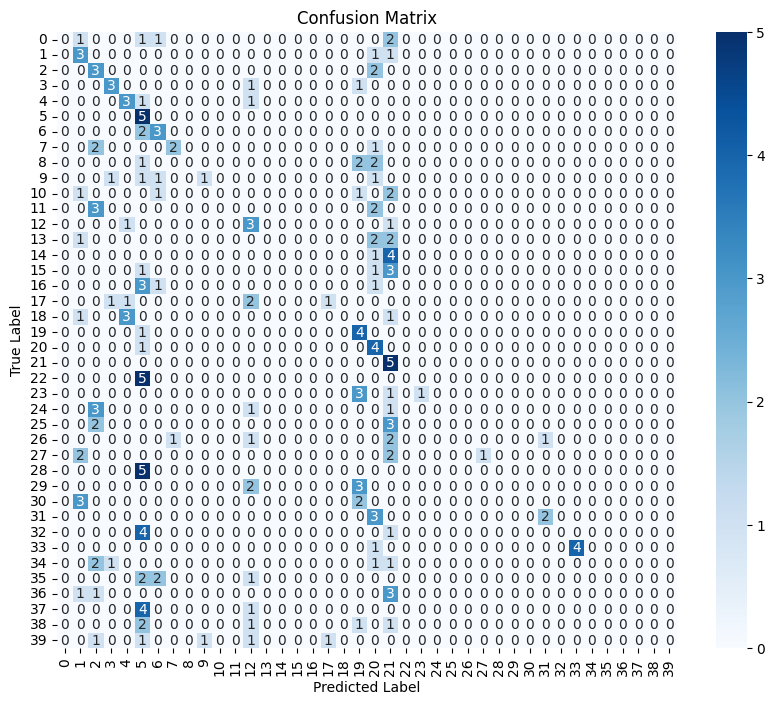


--- Testing Alpha=0.8, K=60 ---
Iter 1, log-likelihood: -21989.085528
Iter 2, log-likelihood: 8867.617818
Iter 3, log-likelihood: 9248.992792
Iter 4, log-likelihood: 9328.834046
Iter 5, log-likelihood: 9354.093725
Iter 6, log-likelihood: 9354.093725
Converged at iteration 6
Alpha: 0.8, K: 60, Train Accuracy: 75.00%
Alpha: 0.8, K: 60, Test Accuracy: 40.00%


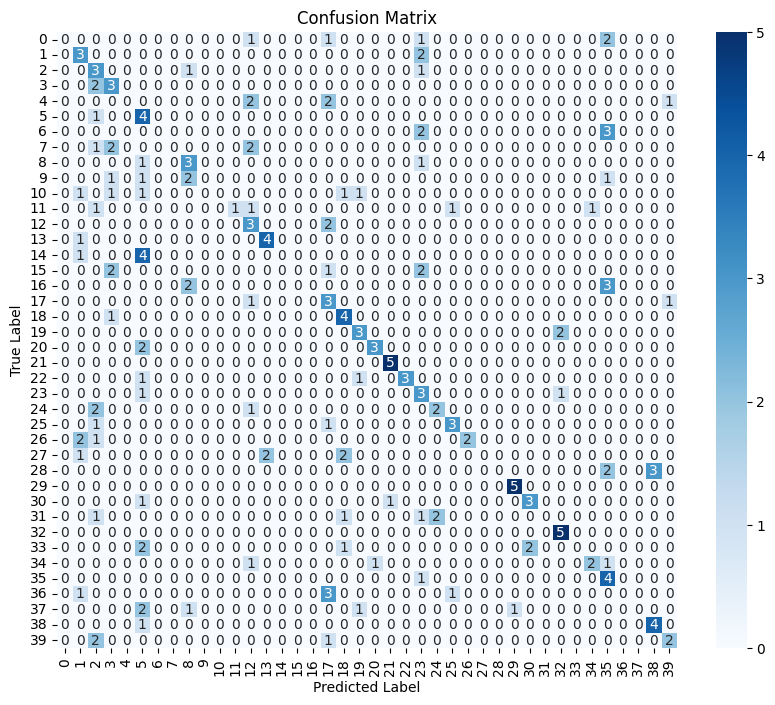


--- Testing Alpha=0.85, K=20 ---
Iter 1, log-likelihood: -52699.504238
Iter 2, log-likelihood: -8625.110290
Iter 3, log-likelihood: -7701.223526
Iter 4, log-likelihood: -7701.223526
Converged at iteration 4
Alpha: 0.85, K: 20, Train Accuracy: 35.50%
Alpha: 0.85, K: 20, Test Accuracy: 14.00%


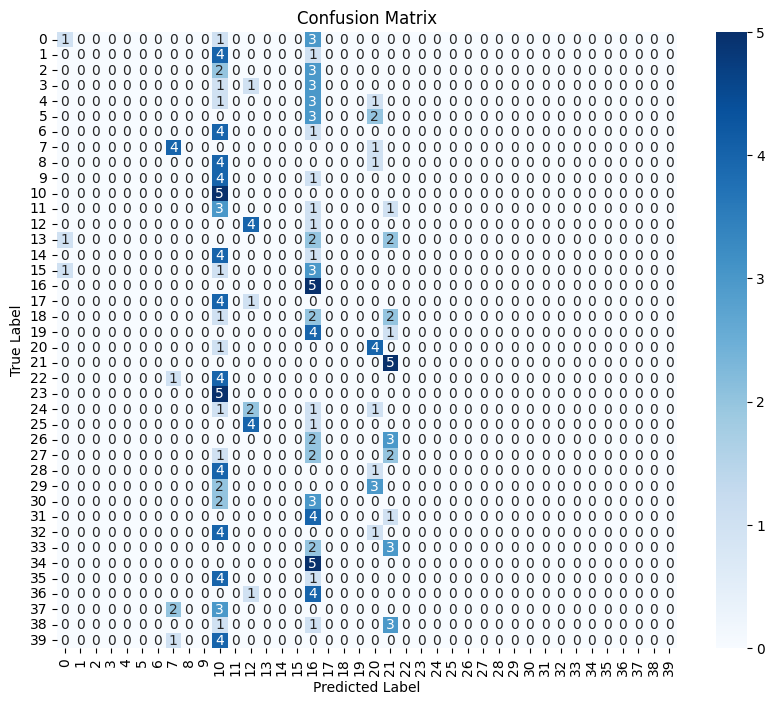


--- Testing Alpha=0.85, K=40 ---
Iter 1, log-likelihood: -35856.884422
Iter 2, log-likelihood: 7714.623632
Iter 3, log-likelihood: 8204.890458
Iter 4, log-likelihood: 8295.042377
Iter 5, log-likelihood: 8295.042377
Converged at iteration 5
Alpha: 0.85, K: 40, Train Accuracy: 52.50%
Alpha: 0.85, K: 40, Test Accuracy: 11.50%


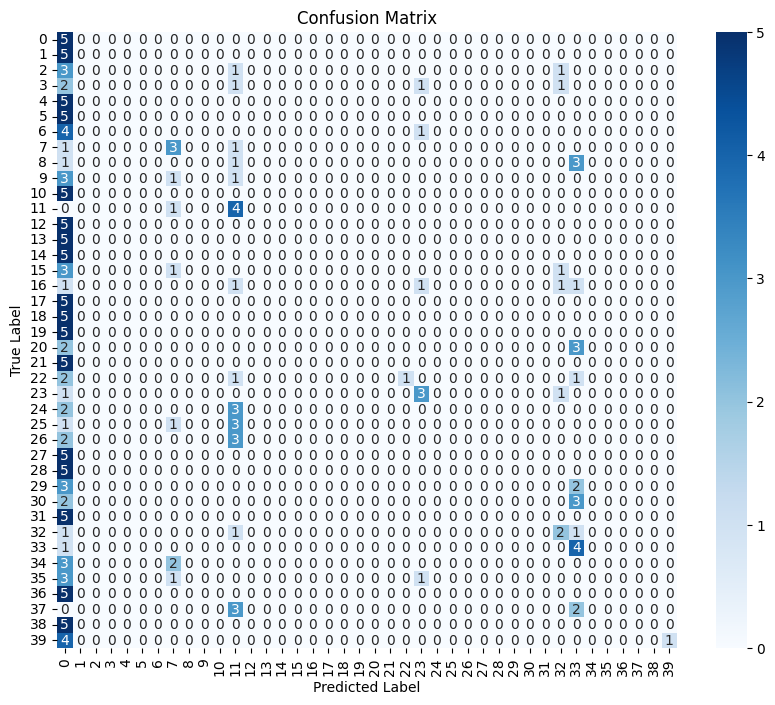


--- Testing Alpha=0.85, K=60 ---
Iter 1, log-likelihood: -21103.113186
Iter 2, log-likelihood: 11802.420715
Iter 3, log-likelihood: 12680.521903
Iter 4, log-likelihood: 12680.524388
Iter 5, log-likelihood: 12680.524388
Converged at iteration 5
Alpha: 0.85, K: 60, Train Accuracy: 70.00%
Alpha: 0.85, K: 60, Test Accuracy: 29.00%


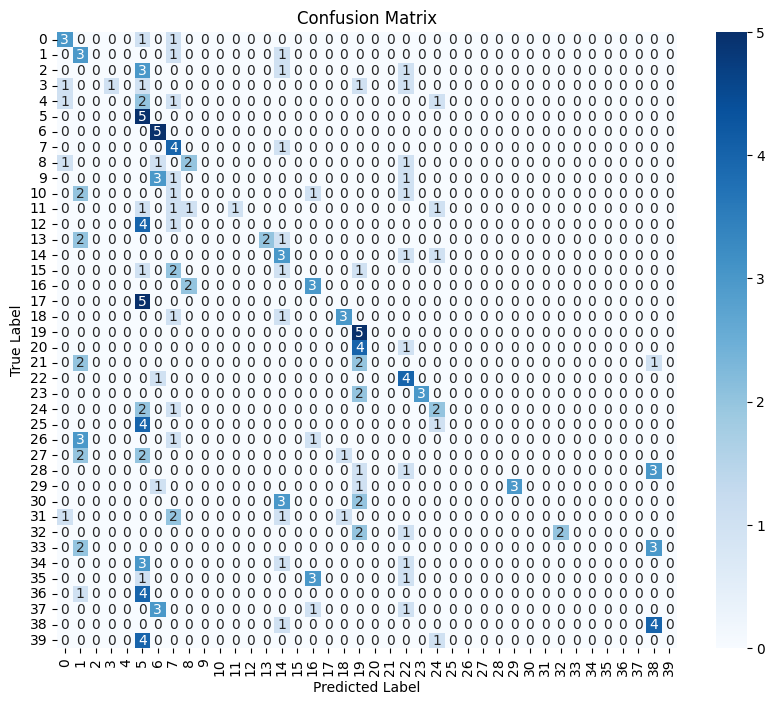


--- Testing Alpha=0.9, K=20 ---
Iter 1, log-likelihood: -67100.540417
Iter 2, log-likelihood: -7375.928369
Iter 3, log-likelihood: -7208.456319
Iter 4, log-likelihood: -7165.889916
Iter 5, log-likelihood: -7165.889913
Iter 6, log-likelihood: -7165.889913
Converged at iteration 6
Alpha: 0.9, K: 20, Train Accuracy: 30.50%
Alpha: 0.9, K: 20, Test Accuracy: 2.50%


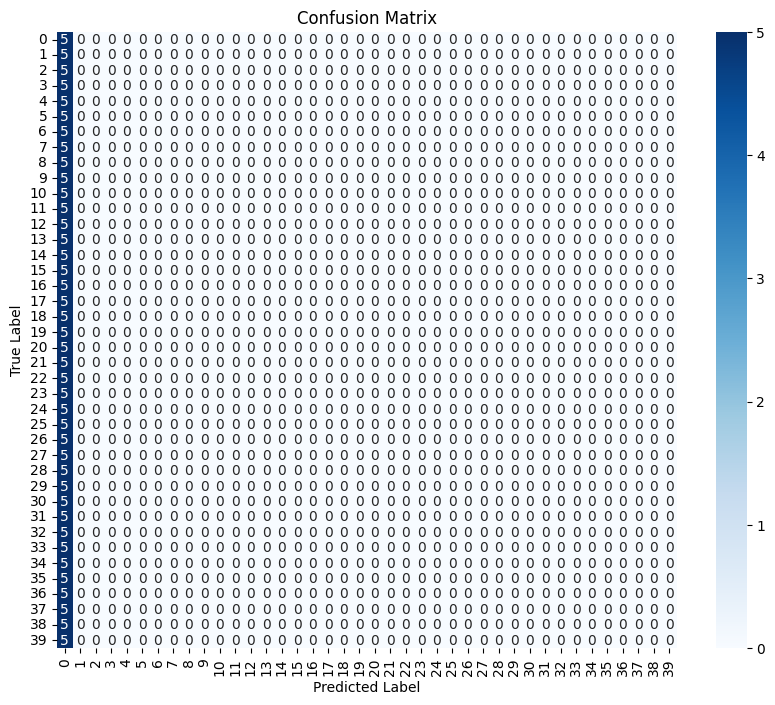


--- Testing Alpha=0.9, K=40 ---
Iter 1, log-likelihood: -41411.756585
Iter 2, log-likelihood: 11964.355019
Iter 3, log-likelihood: 12590.086261
Iter 4, log-likelihood: 12590.086261
Iter 5, log-likelihood: 12590.086261
Converged at iteration 5
Alpha: 0.9, K: 40, Train Accuracy: 47.00%
Alpha: 0.9, K: 40, Test Accuracy: 9.00%


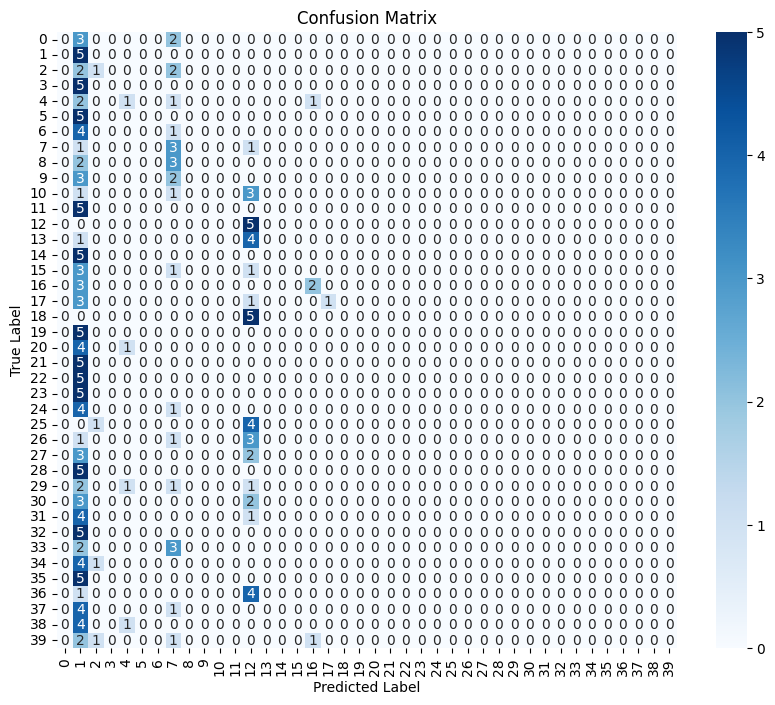


--- Testing Alpha=0.9, K=60 ---
Iter 1, log-likelihood: -20455.599339
Iter 2, log-likelihood: 18501.887961
Iter 3, log-likelihood: 18839.946912
Iter 4, log-likelihood: 18839.946912
Converged at iteration 4
Alpha: 0.9, K: 60, Train Accuracy: 61.50%
Alpha: 0.9, K: 60, Test Accuracy: 22.00%


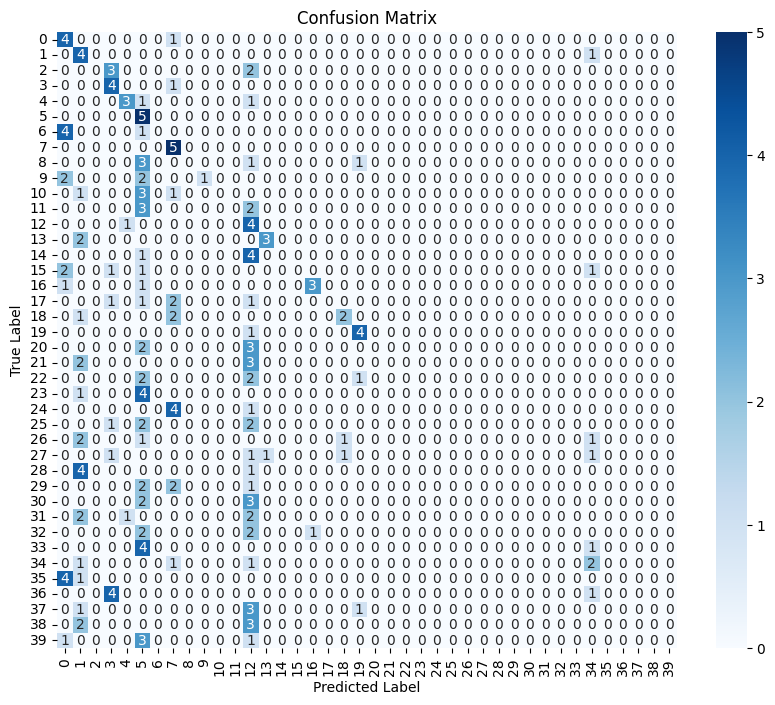


--- Testing Alpha=0.95, K=20 ---
Iter 1, log-likelihood: -103797.104499
Iter 2, log-likelihood: -39169.910641
Iter 3, log-likelihood: -38169.580613
Iter 4, log-likelihood: -38169.580613
Converged at iteration 4
Alpha: 0.95, K: 20, Train Accuracy: 22.00%
Alpha: 0.95, K: 20, Test Accuracy: 2.50%


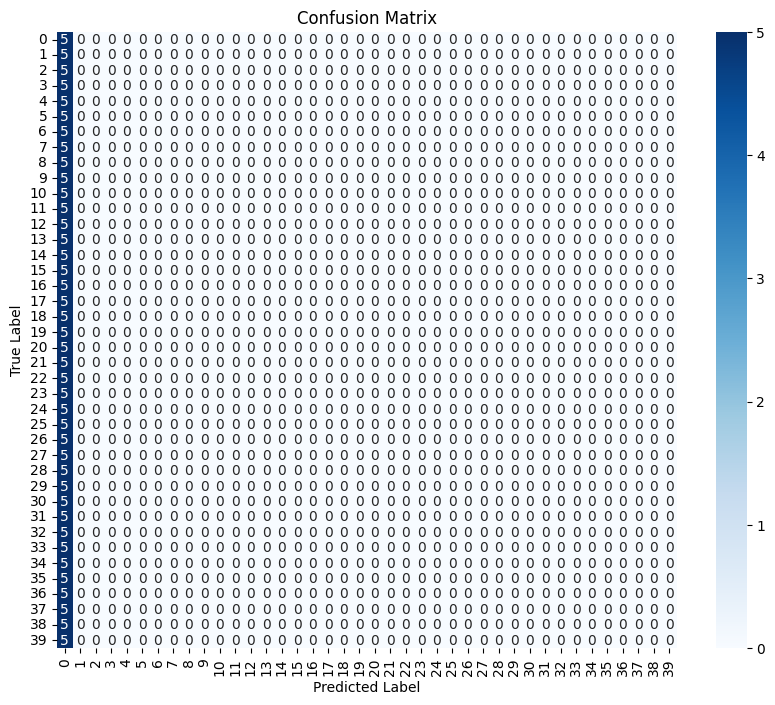


--- Testing Alpha=0.95, K=40 ---
Iter 1, log-likelihood: -54946.228928
Iter 2, log-likelihood: 6187.519159
Iter 3, log-likelihood: 6625.872861
Iter 4, log-likelihood: 6625.872861
Converged at iteration 4
Alpha: 0.95, K: 40, Train Accuracy: 39.00%
Alpha: 0.95, K: 40, Test Accuracy: 2.50%


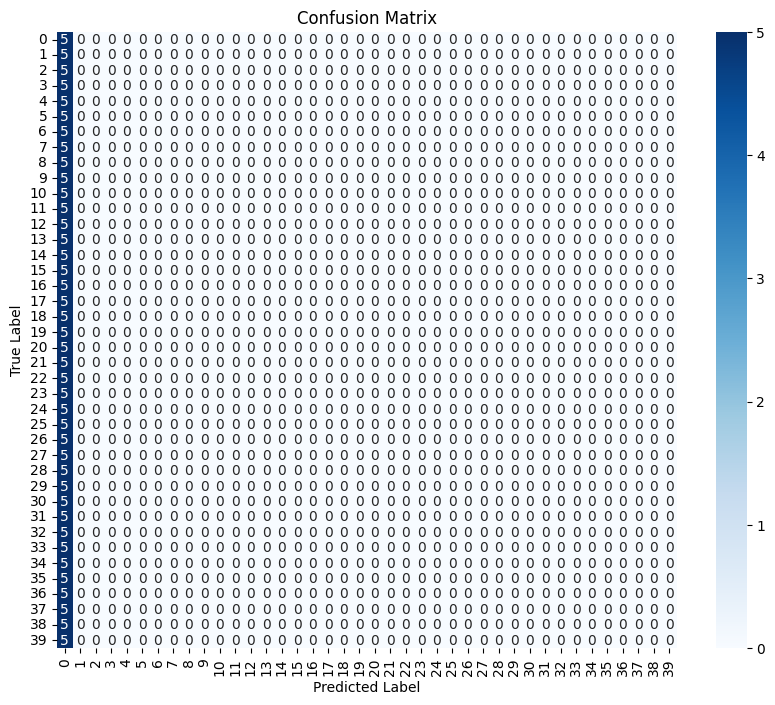


--- Testing Alpha=0.95, K=60 ---
Iter 1, log-likelihood: -27557.582945
Iter 2, log-likelihood: 21617.518029
Iter 3, log-likelihood: 22061.517621
Iter 4, log-likelihood: 22061.517621
Converged at iteration 4
Alpha: 0.95, K: 60, Train Accuracy: 47.00%
Alpha: 0.95, K: 60, Test Accuracy: 2.50%


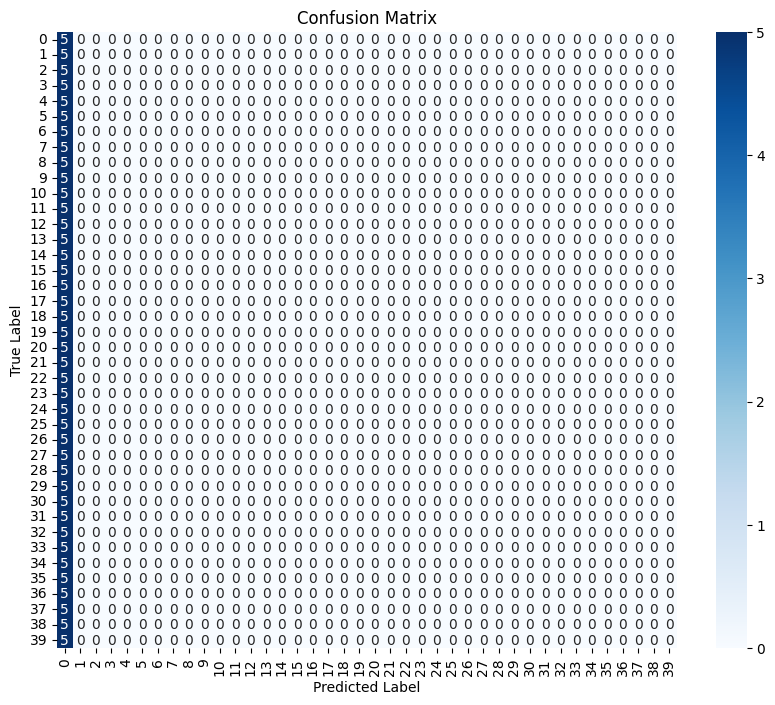

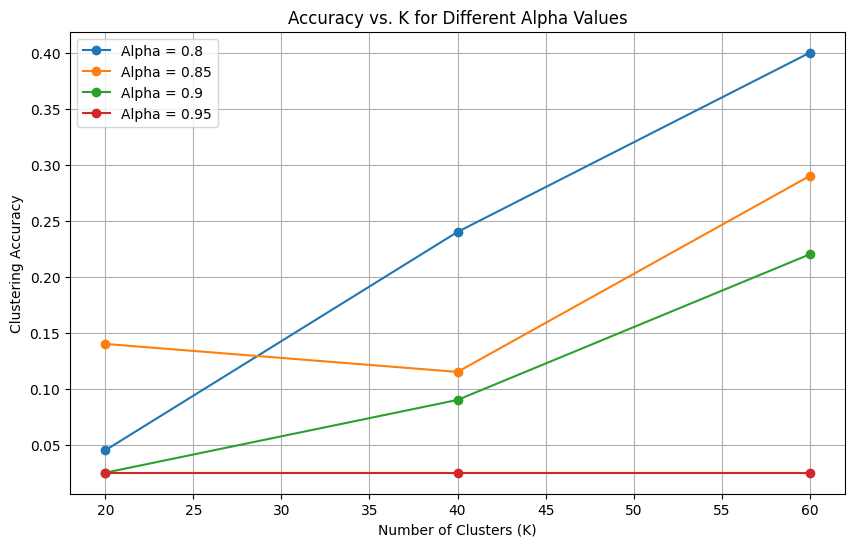

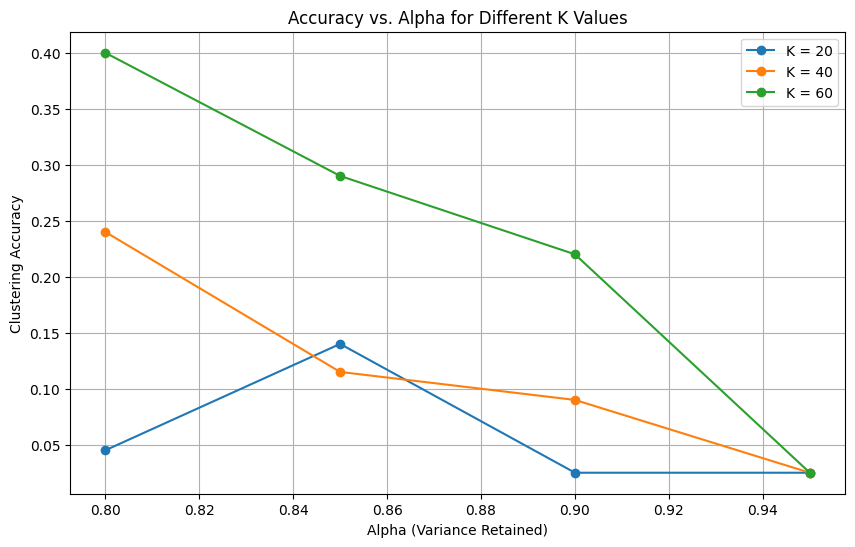

In [11]:

# Updated grid search code with gmm_accuracy function

import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Define alpha and K values
alpha_values = [0.8, 0.85, 0.9, 0.95]
K_values = [20, 40, 60]

# Store results
results = []
test_results = []

# Loop over alpha and K values
for alpha in alpha_values:
    pca = PCA(alpha=alpha)
    Z = pca.fit_transform(X_train)  # Apply PCA with current alpha
    Z_test = pca.fit_transform(X_test)
    
    for K in K_values:
        print(f"\n--- Testing Alpha={alpha}, K={K} ---")
        GMM_model = GMM(K=K)
        GMM_model.fit(Z)  # Fit GMM with current K
        
        # Compute clustering accuracy
        accuracy, predicted_labels, cluster_mapping = gmm_accuracy(GMM_model, Z, y_train)
        test_accuracy, test_predicted_labels, test_cluster_mapping = gmm_accuracy(GMM_model,Z_test, y_test)
        results.append((alpha, K, accuracy))
        test_results.append((alpha, K, test_accuracy))
        print(f"Alpha: {alpha}, K: {K}, Train Accuracy: {accuracy * 100:.2f}%")
        print(f"Alpha: {alpha}, K: {K}, Test Accuracy: {test_accuracy * 100:.2f}%")

        # Visualize confusion matrix


        cm = confusion_matrix(y_test, test_predicted_labels)
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.title('Confusion Matrix')
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.show()

# Convert results to a structured array for easier plotting
test_results = np.array(test_results, dtype=[('alpha', float), ('K', int), ('accuracy', float)])

# Plot Accuracy vs. K for each alpha
plt.figure(figsize=(10, 6))
for alpha in alpha_values:
    subset = test_results[test_results['alpha'] == alpha]
    plt.plot(subset['K'], subset['accuracy'], marker='o', label=f'Alpha = {alpha}')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Clustering Accuracy')
plt.title('Accuracy vs. K for Different Alpha Values')
plt.legend()
plt.grid()
plt.show()

# Plot Accuracy vs. Alpha for each K
plt.figure(figsize=(10, 6))
for K in K_values:
    subset = test_results[test_results['K'] == K]
    plt.plot(subset['alpha'], subset['accuracy'], marker='o', label=f'K = {K}')
plt.xlabel('Alpha (Variance Retained)')
plt.ylabel('Clustering Accuracy')
plt.title('Accuracy vs. Alpha for Different K Values')
plt.legend()
plt.grid()
plt.show()

In [ ]:

# Updated grid search code with gmm_accuracy function

import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Define alpha and K values
alpha_values = [0.8, 0.85, 0.9, 0.95]
K_values = [20, 40, 60]

# Store results
results = []

# Loop over alpha and K values
for alpha in alpha_values:
    pca = PCA(alpha=alpha)
    Z = pca.fit_transform(X_test)  # Apply PCA with current alpha
    
    for K in K_values:
        print(f"\n--- Testing Alpha={alpha}, K={K} ---")
        GMM_model = GMM(K=K)
        GMM_model.fit(Z)  # Fit GMM with current K
        
        # Compute clustering accuracy
        accuracy, predicted_labels, cluster_mapping = gmm_accuracy(GMM_model, Z, y_train)
        results.append((alpha, K, accuracy))
        print(f"Alpha: {alpha}, K: {K}, Accuracy: {accuracy * 100:.2f}%")
        # Visualize confusion matrix


        cm = confusion_matrix(y_train, predicted_labels)
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.title('Confusion Matrix')
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.show()

# Convert results to a structured array for easier plotting
results = np.array(results, dtype=[('alpha', float), ('K', int), ('accuracy', float)])

# Plot Accuracy vs. K for each alpha
plt.figure(figsize=(10, 6))
for alpha in alpha_values:
    subset = results[results['alpha'] == alpha]
    plt.plot(subset['K'], subset['accuracy'], marker='o', label=f'Alpha = {alpha}')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Clustering Accuracy')
plt.title('Accuracy vs. K for Different Alpha Values')
plt.legend()
plt.grid()
plt.show()

# Plot Accuracy vs. Alpha for each K
plt.figure(figsize=(10, 6))
for K in K_values:
    subset = results[results['K'] == K]
    plt.plot(subset['alpha'], subset['accuracy'], marker='o', label=f'K = {K}')
plt.xlabel('Alpha (Variance Retained)')
plt.ylabel('Clustering Accuracy')
plt.title('Accuracy vs. Alpha for Different K Values')
plt.legend()
plt.grid()
plt.show()